# Week 7: Nearest Neighbors, Logistic Regression, and LDA

This week, we will learn about a number of different classification methods that are in common usage, including $k$-nearest-neighbors ($k$-NN), logistic regression, and linear discriminant analysis (LDA). There are further variants of each type although our focus will be on the core approaches.

An array of classifiers are used on a few datasets in the code below from [scikit-learn](https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html)

Automatically created module for IPython interactive environment


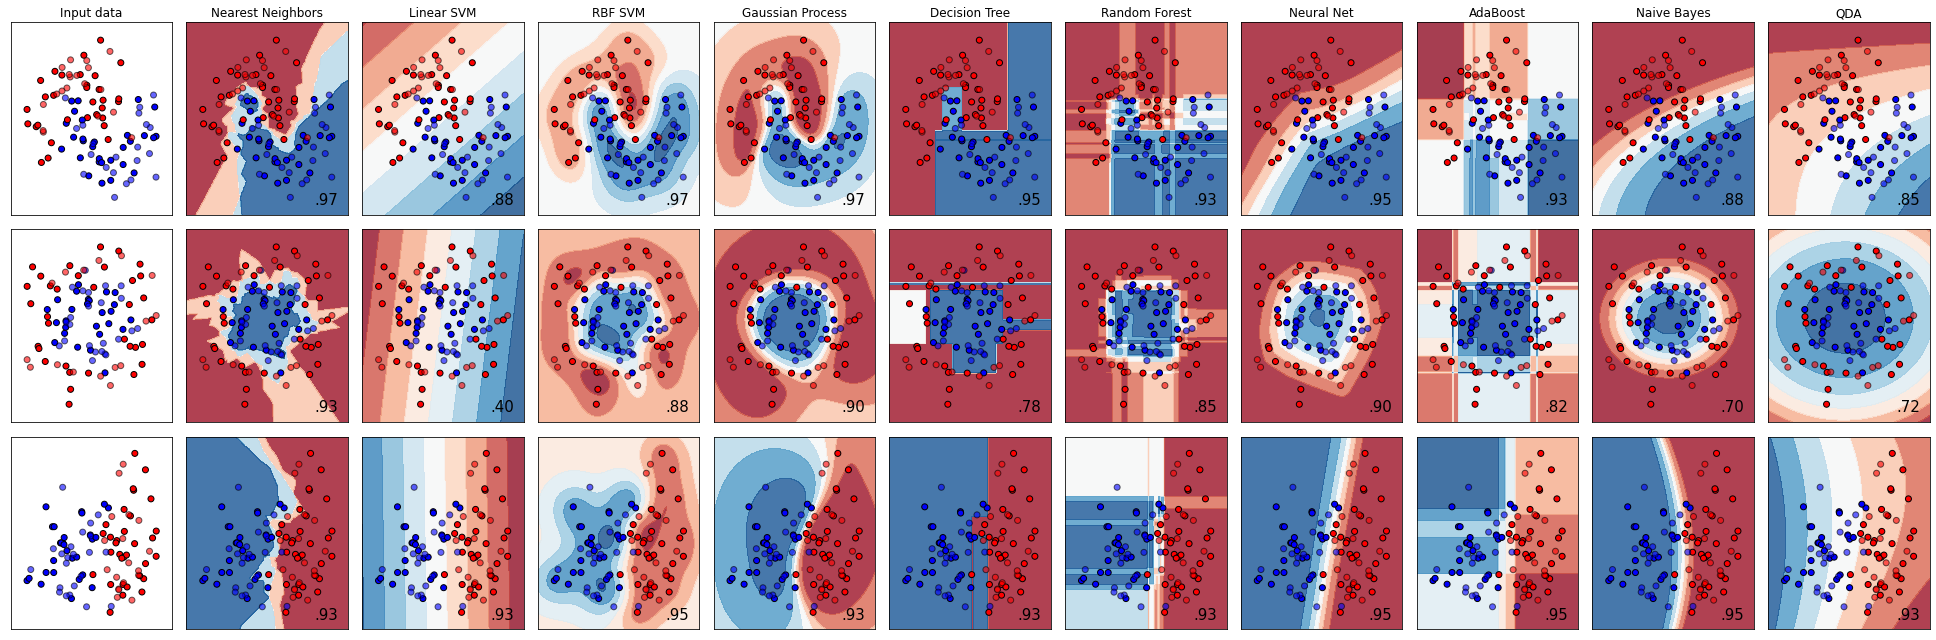

In [1]:
print(__doc__)


# Code source: Gaël Varoquaux
#              Andreas Müller
# Modified for documentation by Jaques Grobler
# License: BSD 3 clause

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

h = .02  # step size in the mesh

names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

X, y = make_classification(n_features=2, n_redundant=0, n_informative=2,
                           random_state=1, n_clusters_per_class=1)
rng = np.random.RandomState(2)
X += 2 * rng.uniform(size=X.shape)
linearly_separable = (X, y)

datasets = [make_moons(noise=0.3, random_state=0),
            make_circles(noise=0.2, factor=0.5, random_state=1),
            linearly_separable
            ]

figure = plt.figure(figsize=(27, 9))
i = 1
# iterate over datasets
for ds_cnt, ds in enumerate(datasets):
    # preprocess dataset, split into training and test part
    X, y = ds
    X = StandardScaler().fit_transform(X)
    X_train, X_test, y_train, y_test = \
        train_test_split(X, y, test_size=.4, random_state=42)

    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # just plot the dataset first
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
    if ds_cnt == 0:
        ax.set_title("Input data")
    # Plot the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
               edgecolors='k')
    # Plot the testing points
    ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6,
               edgecolors='k')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    i += 1

    # iterate over classifiers
    for name, clf in zip(names, classifiers):
        ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)

        # Plot the decision boundary. For that, we will assign a color to each
        # point in the mesh [x_min, x_max]x[y_min, y_max].
        if hasattr(clf, "decision_function"):
            Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
        else:
            Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)

        # Plot the training points
        ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
                   edgecolors='k')
        # Plot the testing points
        ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright,
                   edgecolors='k', alpha=0.6)

        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
        ax.set_xticks(())
        ax.set_yticks(())
        if ds_cnt == 0:
            ax.set_title(name)
        ax.text(xx.max() - .3, yy.min() + .3, ('%.2f' % score).lstrip('0'),
                size=15, horizontalalignment='right')
        i += 1

plt.tight_layout()
plt.show()

Any of the methods above are good choices in some cases, but they each have strengths and weaknesses and work in very different ways. My hope is that you will build enough understanding of classification problems that you will easily be able to deploy any algorithm you choose.

## Lecture 17: $k$-Nearest Neighbors Classifier

The $k$-nearest neighbor classifier tries to classify numerical examples into categories. Suppose we have some labeled examples $x_1, ..., x_n\in\mathbb{R}^d$ with labels $y_1, ..., y_n$. If we have a new, unlabeled point $x$, we would like to predict its class label. The idea of the $k$-nearest neighbor algorithm is that we take the $k$ labeled examples nearest to $x$ and assign the most frequent class of these nearest "neighbors" to $x$.

### The Procedure to Classify an Example $x$ with $k$-Nearest Neighbors

1. Choose a positive integer for $k$.

1. Find the distances $\left\|x-x_j\right\|$ for each $j=1,...,n$ with any norm you choose.

1. Find the points with the $k$ shortest distances from $x$ (the $k$ nearest "neighbors").

1. Assign the most frequent class among the $k$ nearest neighbors to $x$

This means we need to make only two decisions two use the $k$-nearest neighbors: we need to choose a norm and we need to choose the number of neighbors $k$ to use. Customizable parameters for a machine learning method like this $k$-nearest neighbor classifier are called **hyperparameters**. It is not generally obvious how to choose these hyperparameters and it tends to be pretty experimental. Tuning hyperparameters is a large part of machine learning.

### $k$-Nearest Neighbor Code

Let's write some code. I will use the style used by the popular machine learning library <a href="https://scikit-learn.org/stable/">scikit-learn</a>, where a classifier is written as a class in the programming sense (not to be confused with the "classes" of our classification problem) with hyperparameters as inputs. The classifier's class will have some functions that fit the model to the data and predict the class of input datapoints.

The 'fit' function for the $k$-nearest neighbors will do very little but record some data. The 'predict' function will carry out steps 1-4 above.

First, we import some libraries.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sn

from scipy.stats import mode
from sklearn import datasets
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from tensorflow.keras.datasets import mnist

In [3]:
# Create a class for the k-nearest neighbor classifier
class kNearestNeighborClassifier:
    # constructor to save the hyperparameter k
    def __init__(self, k = 5):
        # initialize the number of neighbors to use
        self.neighbors = k
    
    # fit the model to the training data (for kNN, there's no actual fitting involved)
    def fit(self, X, y):
            
        # record the data and labels
        self.data = X
        self.labels = y
    
    # use the classifier to predict the classifications of the testing data
    def predict(self, X):
        # initialize the predicted classes
        yPredicted = np.empty([X.shape[0],1])
        
        # loop over the datapoints in X
        for row in range(X.shape[0]):
            datapoint = X[row,]
            
            # find the distances from the datapoint to each training point using the L2 norm
            distances = np.sqrt(np.sum(((self.data - datapoint)**2), axis = 1))
            
            # find the indices of the smallest k distances
            indices = np.argsort(distances)[:self.neighbors]
            
            # find the the class labels of the nearest neighbors
            nearestClasses = self.labels[indices]
            
            # determine the predicted class by finding the mode
            yPredicted[row] = int(mode(nearestClasses)[0][0])
            
        return yPredicted

### Example: Randomly Generated Points

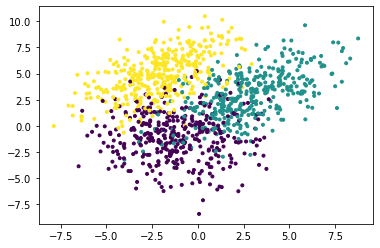

In [4]:
# number of points to generate
numberOfPoints = 500

# generate points from class 0
mean1 = np.array([-1, -1])
covariance1 = np.array([[5, 0], [0, 5]])
X1 = np.random.multivariate_normal(mean1, covariance1, numberOfPoints)

# generate points from class 1
mean2 = np.array([3, 3])
covariance2 = np.array([[5, 3], [3, 5]])
X2 = np.random.multivariate_normal(mean2, covariance2, numberOfPoints)

# generate points from class 2
mean3 = np.array([-2, 5])
covariance3 = np.array([[5, 3], [3, 5]])
X3 = np.random.multivariate_normal(mean3, covariance3, numberOfPoints)

# stack the points
X = np.vstack((X1, X2, X3))

# create a vector of the labels
Y = np.hstack((numberOfPoints * [0], numberOfPoints * [1], numberOfPoints * [2]))

# randomly choose 75% of the data to be the training set and 25% for the testing set
trainX, testX, trainY, testY = train_test_split(X, Y, test_size = 0.25, random_state = 1)

# plot the training set
plt.scatter(trainX[:,0], trainX[:,1], c = trainY, marker = '.')


Classification Report:

               precision    recall  f1-score   support

           0       0.77      0.80      0.79       120
           1       0.83      0.80      0.81       127
           2       0.88      0.90      0.89       128

    accuracy                           0.83       375
   macro avg       0.83      0.83      0.83       375
weighted avg       0.83      0.83      0.83       375


Confusion Matrix:



<AxesSubplot:>

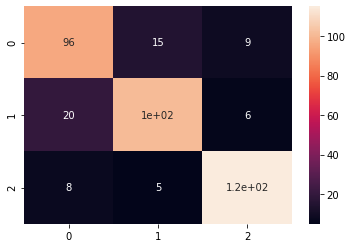

In [5]:
# fit the model to the training data
model = kNearestNeighborClassifier(k = 3)
model.fit(trainX,trainY)

# predict the labels of the test set
predictedY = model.predict(testX)

plt.scatter(trainX[:,0], trainX[:,1], c = trainY, marker = '.')

# print quality metrics
print('\nClassification Report:\n\n', classification_report(testY, predictedY))
print('\nConfusion Matrix:\n')

sn.heatmap(confusion_matrix(testY, predictedY), annot = True)

The code above computes the neighbors in a pretty brute-force way, which is pretty slow, so it is generally best to use an existing implementation like `KNeighborsClassifier` in `scikit-learn`.


Classification Report:

               precision    recall  f1-score   support

           0       0.77      0.80      0.79       120
           1       0.83      0.80      0.81       127
           2       0.88      0.90      0.89       128

    accuracy                           0.83       375
   macro avg       0.83      0.83      0.83       375
weighted avg       0.83      0.83      0.83       375


Confusion Matrix:



<AxesSubplot:>

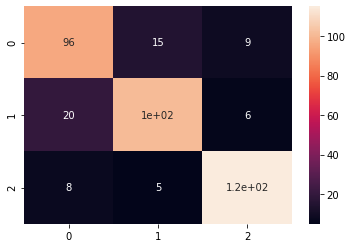

In [6]:
# fit the model to the training data
model = KNeighborsClassifier(3)
model.fit(trainX,trainY)

# predict the labels of the test set
predictedY = model.predict(testX)

plt.scatter(trainX[:,0], trainX[:,1], c = trainY, marker = '.')

# print quality metrics
print('\nClassification Report:\n\n', classification_report(testY, predictedY))
print('\nConfusion Matrix:\n')

sn.heatmap(confusion_matrix(testY, predictedY), annot = True)


Classification Report:

               precision    recall  f1-score   support

           0       0.78      0.81      0.79       120
           1       0.82      0.78      0.80       127
           2       0.88      0.90      0.89       128

    accuracy                           0.83       375
   macro avg       0.83      0.83      0.83       375
weighted avg       0.83      0.83      0.83       375


Confusion Matrix:



<AxesSubplot:>

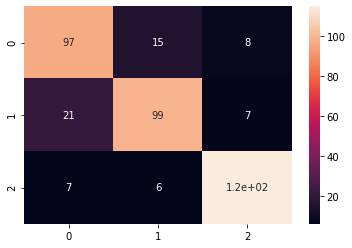

In [7]:
# fit the model to the training data
model = KNeighborsClassifier(n_neighbors = 3, weights = 'distance')
model.fit(trainX,trainY)

# predict the labels of the test set
predictedY = model.predict(testX)

plt.scatter(trainX[:,0], trainX[:,1], c = trainY, marker = '.')

# print quality metrics
print('\nClassification Report:\n\n', classification_report(testY, predictedY))
print('\nConfusion Matrix:\n')

sn.heatmap(confusion_matrix(testY, predictedY), annot = True)

### Classifying MNIST Handwritten Digits with $k$-NN

Dev classification accuracy 1 neighbors is 0.871
Dev classification accuracy 2 neighbors is 0.85
Dev classification accuracy 3 neighbors is 0.853
Dev classification accuracy 4 neighbors is 0.854
Dev classification accuracy 5 neighbors is 0.838
Dev classification accuracy 6 neighbors is 0.839
Dev classification accuracy 7 neighbors is 0.83
Dev classification accuracy 8 neighbors is 0.836
Dev classification accuracy 9 neighbors is 0.821
Dev classification accuracy 10 neighbors is 0.819

The best dev accuracy 0.871 occured with 1 neghbors

Test Classification Report for 0.871 neighbors:

               precision    recall  f1-score   support

           0       0.91      0.97      0.94        97
           1       0.88      1.00      0.94       106
           2       0.94      0.89      0.91       108
           3       0.92      0.83      0.87       120
           4       0.85      0.83      0.84        87
           5       0.72      0.73      0.73        75
           6       0.92     

<AxesSubplot:>

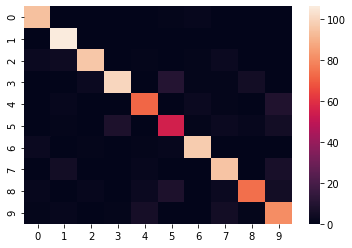

In [8]:
(trainX, trainY), (testX, testY) = mnist.load_data()

trainX = trainX.reshape(trainX.shape[0], trainX.shape[1] * trainX.shape[2]).astype('float')/255.0
testX = testX.reshape(testX.shape[0], testX.shape[1] * testX.shape[2]).astype('float')/255.0

devX, testX, devY, testY = train_test_split(testX, testY, test_size = 0.5)

trainX = trainX[:1000]
devX = devX[:1000]
testX = testX[:1000]
trainY = trainY[:1000]
devY = devY[:1000]
testY = testY[:1000]

bestAccuracy = [0, 0]

for k in range(1, 11):
    # build the knn classifier
    model = KNeighborsClassifier(k)

    # fit the knn classifier to the training data
    model.fit(trainX, trainY)

    # predict the labels of the test set
    predictedY = model.predict(devX)
    
    # compute the accuracy
    acc = accuracy_score(devY, predictedY)
    
    # print quality metrics
    print('Dev classification accuracy', k, 'neighbors is', acc)
    
    # save the hyperparameter k if better than found before
    if acc > bestAccuracy[0]:
        bestAccuracy = [acc, k]
        
print('\nThe best dev accuracy', bestAccuracy[0], 'occured with', bestAccuracy[1], 'neghbors')
        
# build the knn classifier
model = KNeighborsClassifier(bestAccuracy[1])

# fit the knn classifier to the training data
model.fit(trainX, trainY)

# predict the labels of the test set
predictedY = model.predict(testX)

# print quality metrics
print('\nTest Classification Report for', bestAccuracy[0], 'neighbors:\n\n', classification_report(testY, predictedY))
print('\nTest Confusion Matrix:\n')

sn.heatmap(confusion_matrix(testY, predictedY))

Mean CV accuracy for 1 neighbors is 0.9393
Mean CV accuracy for 2 neighbors is 0.9307000000000001
Mean CV accuracy for 3 neighbors is 0.9395000000000001
Mean CV accuracy for 4 neighbors is 0.9405000000000001
Mean CV accuracy for 5 neighbors is 0.9377000000000001
Mean CV accuracy for 6 neighbors is 0.9362999999999999
Mean CV accuracy for 7 neighbors is 0.9359999999999999
Mean CV accuracy for 8 neighbors is 0.9343999999999999
Mean CV accuracy for 9 neighbors is 0.9345000000000001
Mean CV accuracy for 10 neighbors is 0.9341000000000002

The best dev accuracy 0.9405000000000001 occured with 4 neghbors

Test Classification Report for 0.9405000000000001 neighbors:

               precision    recall  f1-score   support

           0       0.94      0.99      0.96       980
           1       0.91      0.99      0.95      1135
           2       0.97      0.92      0.95      1032
           3       0.92      0.95      0.94      1010
           4       0.96      0.95      0.95       982
      

<AxesSubplot:>

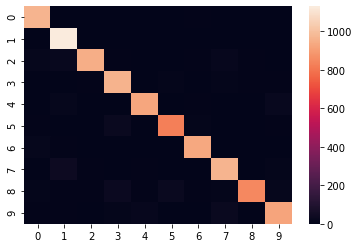

In [9]:
(trainX, trainY), (testX, testY) = mnist.load_data()

trainX = trainX.reshape(trainX.shape[0], trainX.shape[1] * trainX.shape[2]).astype('float')/255.0
testX = testX.reshape(testX.shape[0], testX.shape[1] * testX.shape[2]).astype('float')/255.0

trainX = trainX[:10000]
testX = testX[:10000]
trainY = trainY[:10000]
testY = testY[:10000]

bestAccuracy = [0, 0]

for k in range(1, 11):
    # build the knn classifier
    model = KNeighborsClassifier(k)

    # fit the knn classifier to the training data
    model.fit(trainX, trainY)
    
    mean_cv_scores = np.mean(cross_val_score(model, trainX, trainY, cv = 5))

    # print quality metrics
    print('Mean CV accuracy for', k, 'neighbors is', mean_cv_scores)
    
    # save the hyperparameter k if better than found before
    if mean_cv_scores > bestAccuracy[0]:
        bestAccuracy = [mean_cv_scores, k]
        
print('\nThe best dev accuracy', bestAccuracy[0], 'occured with', bestAccuracy[1], 'neghbors')
        
# build the knn classifier
model = KNeighborsClassifier(bestAccuracy[1])

# fit the knn classifier to the training data
model.fit(trainX, trainY)

# predict the labels of the test set
predictedY = model.predict(testX)

# print quality metrics
print('\nTest Classification Report for', bestAccuracy[0], 'neighbors:\n\n', classification_report(testY, predictedY))
print('\nTest Confusion Matrix:\n')

sn.heatmap(confusion_matrix(testY, predictedY))

This is quite good accuracy at 94%!

## Lecture 18: Logistic Regression

In class, we discussed the logistic regression model for both binary classification and multiclass classification.

### Binary Logistic Regression

In this case, we predict binary labels $Y\in\{0, 1\}$. Fitting the model simplifies to minimizing the **binary cross-entropy** loss function

$$L(\theta)=-\sum\limits_{i=1}^n y_i\ln\left(\sigma\left(\theta^Tx_i\right)\right)+(1-y_i)\ln\left(\sigma\left(-\theta^Tx_i\right)\right)$$

where $\theta=(\theta_0, \theta_1, ..., \theta_d)^T$ are parameters of the model and $\sigma:\mathbb{R}\to\mathbb{R}$ is the **logistic** or **sigmoid** function

$$\sigma(z)=\frac{1}{1+e^{-z}}=\frac{e^z}{1+e^z}$$

In class, we showed

$$\frac{\partial L}{\partial\theta}=\sum\limits_{i=1}^n\left(\sigma\left(\theta^Tx\right)-y_i\right)x_i$$

To code logistic regression, let's first import some libraries.

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sn

from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from tensorflow.keras.datasets import mnist

Next, we implement binary logistic regression.

In [11]:
class BinaryLogisticRegression:        
    def fit(self, X, y, alpha, epochs, eps, update):
        # add a column of 1s to X
        X = np.hstack((np.ones([X.shape[0],1]), X))
            
        # modify y to be n by 1
        y = np.atleast_2d(y).T
        
        # initialize the parameters to 1
        self.theta = np.ones([X.shape[1], 1])
        
        # initialize the step number and theta gradient
        step = 0
        thetagrad = 2 * eps
        
        # minimize cross-entropy -- run until thetagrad is small or step is epochs
        while np.linalg.norm(thetagrad) > eps and step < epochs:
            # compute the loss
            sig = self.sigmoid(X @ self.theta)
            
            if step % update == 0:
                loss = -(1/X.shape[0]) * np.sum(y * np.log(sig + 0.001) + (1 - y) * np.log(1 - sig + 0.001))
                print('Iteration', step, '\tLoss =', loss)
            
            # compute the gradient
            thetagrad = X.T @ (sig - y)
            
            # take a gradient descent step
            self.theta -= alpha * thetagrad
                        
            # iterate the step
            step += 1
            
            if step == epochs:
                print('Gradient descent failed to converge. (The answer may still be acceptably good.)')
            
    def predict(self, X):
        # add a column of 1s to X
        X = np.hstack((np.ones([X.shape[0],1]), X))
        
        # return 0 if the posterior for Y=1 is less than for Y=0
        # otherwise, return 1
        return (self.sigmoid(X @ self.theta) >= 0.5).astype(float)
            
    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

### Example: Detecting Breast Cancer

Iteration 0 	Loss = 2.5127493043473375


<ipython-input-11-dab935165e16>:46: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


Iteration 10000 	Loss = 0.7450162739591704
Iteration 20000 	Loss = 0.6477098686167025
Iteration 30000 	Loss = 0.5666211974979792
Iteration 40000 	Loss = 0.6963630712879365
Iteration 50000 	Loss = 0.5828389317217239
Iteration 60000 	Loss = 0.5504034632742345
Iteration 70000 	Loss = 0.5990566659454686
Iteration 80000 	Loss = 0.5504034632742345
Iteration 90000 	Loss = 0.6152744001692131
Iteration 100000 	Loss = 0.4693147921555113
Iteration 110000 	Loss = 0.8098872108541489
Iteration 120000 	Loss = 0.6477098686167025
Iteration 130000 	Loss = 0.6477098686167025
Iteration 140000 	Loss = 0.6152744001692132
Iteration 150000 	Loss = 0.5990566659454686
Iteration 160000 	Loss = 0.6314921343929578
Iteration 170000 	Loss = 0.5504034632742345
Iteration 180000 	Loss = 0.6477098686167025
Iteration 190000 	Loss = 0.6152744001692132
Iteration 200000 	Loss = 0.5504034632742345
Iteration 210000 	Loss = 0.7450162739591704
Iteration 220000 	Loss = 0.5341857290504899
Iteration 230000 	Loss = 0.55040346327423

<AxesSubplot:>

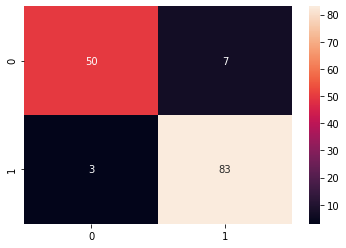

In [12]:
# import the breast cancer dataset
breastcancer = datasets.load_breast_cancer()

# find the data and labels
X = breastcancer.data
Y = breastcancer.target

# split the data into train and test sets
trainX, testX, trainY, testY = train_test_split(X, Y, test_size = 0.25)

# build the classifier
model = BinaryLogisticRegression()

# fit the classifier to the training data
model.fit(trainX, trainY, alpha = 0.01, epochs = 1000000, eps = 0.01, update = 10000)

# predict the labels of the test set
predictedY = model.predict(testX)

# print quality metrics
print('\nClassification Report:\n\n', classification_report(testY, predictedY))
print('\nConfusion Matrix:\n')

sn.heatmap(confusion_matrix(testY, predictedY), annot = True)

The built-in `LogisticRegression` class in `scikit-learn` tends to work a little faster because it uses an optimizer that efficiently uses second derivative information by default. Note that the class uses an $L^2$ penalty if we speciy the variable `C`, where

$$C=\frac{1}{\lambda_2}$$

Tuning this hyperparameter is a good idea to improve performance on the test set.

In [13]:
# import the breast cancer dataset
breastcancer = datasets.load_breast_cancer()

# find the data and labels
X = breastcancer.data
Y = breastcancer.target

# split the data into train and test sets
trainX, testX, trainY, testY = train_test_split(X, Y, test_size = 0.25)

# build the classifier
model = LogisticRegression(C = 10000, max_iter = 10000)

# fit the classifier to the training data
model.fit(trainX, trainY)

# predict the labels of the training set
predictedY = model.predict(trainX)

# print quality metrics
print('\nTraining Classification Report:\n\n', classification_report(trainY, predictedY))

# predict the labels of the test set
predictedY = model.predict(testX)

# print quality metrics
print('\nTesting Classification Report:\n\n', classification_report(testY, predictedY))


Training Classification Report:

               precision    recall  f1-score   support

           0       1.00      1.00      1.00       160
           1       1.00      1.00      1.00       266

    accuracy                           1.00       426
   macro avg       1.00      1.00      1.00       426
weighted avg       1.00      1.00      1.00       426


Testing Classification Report:

               precision    recall  f1-score   support

           0       0.94      0.92      0.93        52
           1       0.96      0.97      0.96        91

    accuracy                           0.95       143
   macro avg       0.95      0.95      0.95       143
weighted avg       0.95      0.95      0.95       143



G:\Miniconda3\envs\DL\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Multiclass Logistic Regression

Logistic regression can also be applied to classification problems with logistic regression. In this case, we predict one-hot vector labels $Y\in\{\mathbf{e}_1, \mathbf{e}_2, ..., \mathbf{e}_k\}$. Fitting the model simplifies to minimizing the **categorical cross-entropy** loss function

$$L(\theta)=-\sum\limits_{i=1}^n\sum\limits_{j=1}^k y_{ij}\ln\left(\sigma\left(\theta^T_j x_i\right)\right)$$

where $\theta_j=(\theta_{j0}, \theta_{j1}, ..., \theta_{jd})^T$ are parameters of the model for $j=1, ..., k$.

In class, we derived the gradient, which can be used in gradient descent as

$$\frac{\partial L}{\partial\theta_l}=\sum\limits_{i=1}^n \left(\pi_l(x_i) - y_{il}\right)x_i=\sum\limits_{i=1}^n\sum\limits_{j=1}^k \left(\sigma\left(\theta^T x_i\right)_l-y_{il}\right)x_i$$

where the **softmax** function $\sigma:\mathbb{R}^k\to\mathbb{R}^k$ is defined in each coordinate as

$$\sigma(z)_i=\frac{e^{z_i}}{\sum\limits_{j=1}^k e^{z_j}}$$

We will simply use the `scikit-learn` class `LogisticRegression` for the multiclass case to avoid some not-so-enlightening code (at least, given that it's just scaling up the binary case).

### Classifying MNIST Handwritten Digits with Logistic Regression


Training Classification Report:

               precision    recall  f1-score   support

           0       0.97      0.98      0.98      5923
           1       0.96      0.98      0.97      6742
           2       0.94      0.92      0.93      5958
           3       0.92      0.91      0.92      6131
           4       0.94      0.95      0.94      5842
           5       0.91      0.91      0.91      5421
           6       0.96      0.97      0.96      5918
           7       0.95      0.95      0.95      6265
           8       0.91      0.90      0.91      5851
           9       0.92      0.92      0.92      5949

    accuracy                           0.94     60000
   macro avg       0.94      0.94      0.94     60000
weighted avg       0.94      0.94      0.94     60000


Testing Classification Report:

               precision    recall  f1-score   support

           0       0.95      0.97      0.96       980
           1       0.96      0.98      0.97      1135
         

<AxesSubplot:>

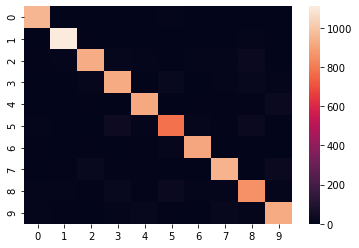

In [14]:
(trainX, trainY), (testX, testY) = mnist.load_data()

trainX = trainX.reshape(trainX.shape[0], trainX.shape[1] * trainX.shape[2])
trainX = trainX.astype('float')/255.0

testX = testX.reshape(testX.shape[0], testX.shape[1] * testX.shape[2])
testX = testX.astype('float')/255.0

# build the classifier
model = LogisticRegression(max_iter = 10000)

# fit the classifier to the training data
model.fit(trainX, trainY)

# predict the labels of the training set
predictedY = model.predict(trainX)

# print quality metrics
print('\nTraining Classification Report:\n\n', classification_report(trainY, predictedY))

# predict the labels of the test set
predictedY = model.predict(testX)

# print quality metrics
print('\nTesting Classification Report:\n\n', classification_report(testY, predictedY))

# predict the labels of the test set
predictedY = model.predict(testX)

print('\nTesting Confusion Matrix:\n')

sn.heatmap(confusion_matrix(testY, predictedY))

We see 93% accuracy on the test set with zero hyperparameter tuning!

## Lecture 19: Linear Discriminant Analysis

We learned the math of LDA and QDA in class today, but will implement next time.